In [61]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.dates as mdates
import logging
import telegram
import emoji
from matplotlib import pyplot as plt
from telegram.ext import Updater, CommandHandler, MessageHandler, Filters
from binance.client import Client
from binance.exceptions import BinanceAPIException
from secrets import secrets

TELEGRAM_CHAT_ID = secrets['TELEGRAM_CHAT_ID']
TELEGRAM_TOKEN = secrets['TELEGRAM_TOKEN']
BINANCE_API_KEY = secrets['BINANCE_API_KEY']
BINANCE_SECRET_KEY = secrets['BINANCE_SECRET_KEY']
BRIDGE = 'USDT'
COINS = []
with open('coins.txt') as f:
    for line in f:
        COINS.append(line.strip('\n'))

In [35]:
cols = ['OpenTime', 'Open', 'High', 'Low', 'Close', 'Volume', 'CloseTime', 'QuoteVolume', 'NumberTrades',
        'TakerBuyBaseVolume', 'TakerBuyQuoteVolume', 'Ignore']
timezone = 8

In [138]:
def get_kline(coin):
    symbol = coin + BRIDGE
    client = Client(BINANCE_API_KEY, BINANCE_SECRET_KEY)
    kline = client.get_klines(symbol=symbol, interval=Client.KLINE_INTERVAL_15MINUTE, limit=96)
    return kline

def line_plot(kline):
    # Format to df
    to_keep = ['CloseTime', 'Close']
    df = pd.DataFrame(kline, columns=cols)
    df = df[to_keep]
    df['CloseTime'] = pd.to_datetime(df['CloseTime'], unit='ms')
    df['CloseTime'] = df['CloseTime'] + pd.DateOffset(hours=timezone)
    df['Close'] = df['Close'].apply(pd.to_numeric, errors='coerce')
    # Plot
    fig = plt.figure(figsize=(12,6))
    plt.style.use('dark_background')
    ax = sns.lineplot(data=df, x='CloseTime', y='Close')
    date_fmt = mdates.DateFormatter('%m-%d %H:%M')
    ax.xaxis.set_major_formatter(date_fmt)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(coin + '-USD Price Chart')
    # Save image
    file_name = coin + '_USD_LINE_CHART.png'
    fig.savefig(file_name)
    return file_name

def candle_plot(kline):
    # Format to df
    num_cols = ['Open', 'High', 'Low', 'Close']
    to_keep = ['CloseTime', 'Open', 'High', 'Low', 'Close']
    df = pd.DataFrame(kline, columns=cols)
    df = df[to_keep]
    df['CloseTime'] = pd.to_datetime(df['CloseTime'], unit='ms')
    df['CloseTime'] = df['CloseTime'] + pd.DateOffset(hours=8)
    df[num_cols] = df[num_cols].apply(pd.to_numeric, errors='coerce')
    # Plot
    fig = plt.figure(figsize=(12,6))
    plt.style.use('dark_background')
    ax = fig.add_subplot()
    for _, row in df.iterrows():
        ax.vlines(x=row['CloseTime'], ymin=row['Low'], ymax=row['High'], color='black', linewidth=1)
        if row['Close'] > row['Open']:
            ax.vlines(x=row['CloseTime'], ymin=row['Open'], ymax=row['Close'], color='green', linewidth=4)
        elif row['Close'] < row['Open']:
            ax.vlines(x=row['CloseTime'], ymin=row['Close'], ymax=row['Open'], color='red', linewidth=4)
        else:
            ax.vlines(x=row['CloseTime'], ymin=row['Open'], ymax=row['Close'], color='black', linewidth=4)
    date_fmt = mdates.DateFormatter('%m-%d %H:%M')
    ax.xaxis.set_major_formatter(date_fmt)
    ax.set_title(coin + '-USD Price Chart')
    # Save image
    file_name = coin + '_USD_CANDLE_CHART.png'
    fig.savefig(file_name)
    return file_name

'BTC_USD_LINE_CHART.png'

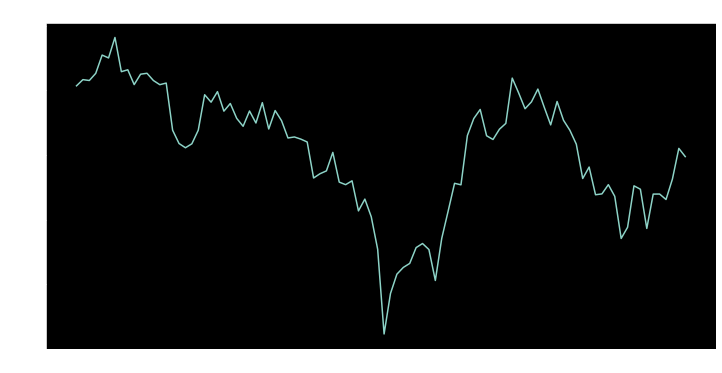

In [139]:
line_plot(get_kline('BTC'))

'BTC_USD_CANDLE_CHART.png'

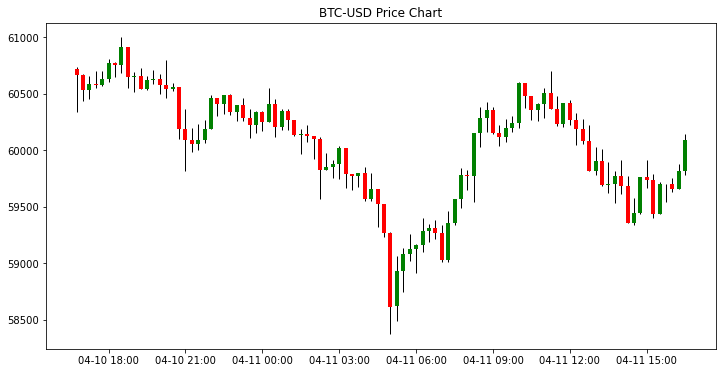

In [122]:
candle_plot('BTC')

In [135]:
import os

def line(update, context):
    try:
        coin = context.args[0].upper()
        kline = get_kline(coin)
    except:
        update.message.reply_text(text='Please provide a valid coin.')
        return
    file_name = line_plot(kline)
    context.bot.send_photo(chat_id=update.message.chat_id, photo=open(file_name, 'rb'),
                           reply_to_message_id=update.message.message_id, allow_sending_without_reply=False)
    os.remove(file_name)

In [136]:
def main():
    updater = Updater(token=TELEGRAM_TOKEN)
    # Bot commands
    dp = updater.dispatcher
    dp.add_handler(CommandHandler('line', line))
    # Job queue
    job_queue = updater.job_queue
    updater.start_polling()
    updater.idle()

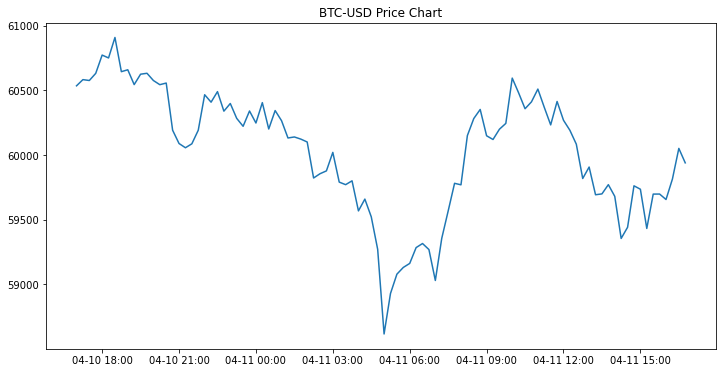

In [137]:
main()